In [1]:
import sys
sys.path.append('../support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from sampler import fitters
from astropy.coordinates import SkyCoord
from astropy.table import Table
import GCRCatalogs



Make sure we know which version we're using

In [2]:
clmm.__version__

'0.2.0'

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

### Read in the extragalactic catalog
- identify the most massive halo
- create a cluster dictionary (ra, dec, z)

In [4]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [5]:
# get list of massive halos in a given redshift and mass range
mmin = 3.e14
mmax = 1.e15
zmin = 0.3
zmax = 0.35

massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=[f'halo_mass > {mmin}',f'halo_mass < {mmax}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'])

In [6]:
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])

In [20]:

ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]

In [21]:
print (ra_cl, dec_cl, z_cl, mass_cl/1.e14)

64.25941267918058 -34.47274791810462 0.32086432759527206 6.356945271908957


### Apply coordinates and redshift cuts to select backgroud galaxies around the cluster

In [29]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5
mag_i_max = 24

coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2','redshift', 'convergence'],\
                                           filters=(coord_filters + z_filters))



In [10]:
e1, e2 = clmm.utils.convert_shapes_to_epsilon(galcat['shear1'],galcat['shear2'], shape_definition='shear',kappa=galcat['convergence'])

store the results into an astropy table
dat = Table([gal_cat['ra'],gal_cat['dec'],e1,\
      e2,gal_cat['redshift'],gal_cat['galaxy_id']], \
      names=('ra','dec', 'e1', 'e2', 'z','id'))

# dat = Table([gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
#       gal_cat['shear_2'],gal_cat['redshift'],gal_cat['galaxy_id']], \
#       names=('ra','dec', 'e1', 'e2', 'z','id'))

cl = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat)   

### Computes the tangential and cross shear profiles

#### Default binning

In [26]:
bin_edges = clmm.polaraveraging.make_bins(0.1, 4, 30, method='evenlog10width')
cl.compute_shear(geometry="flat")
profile = cl.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

Text(0, 0.5, 'reduced tangential shear')

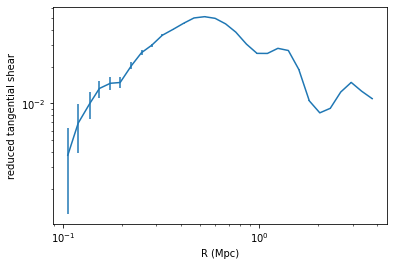

In [27]:
plt.errorbar(profile['radius'],profile['gt'],yerr=profile['gt_err'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('reduced tangential shear')

In [28]:
cl.profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
0.1,0.10599551156076456,0.11308421814734985,0.003771559420379098,0.0025275526308310052,0.004925667554996788,0.0028984496299305136,1.0616052454496383,0.03274740846192794,63
0.11308421814734985,0.11975748834349224,0.12788040393997407,0.00690903026227424,0.002955971938820584,0.0006506318728483056,0.002969205793379913,1.0581053174420885,0.036391327359456084,53
0.12788040393997407,0.1369997860630542,0.14461255495919248,0.009956195287990226,0.002447599744644376,-0.0019404921129885756,0.002344872055885549,1.0921525425380498,0.02723204568866251,76
0.14461255495919248,0.1535670085092488,0.1635339771185094,0.013267923301795435,0.002144904435589672,0.0029765970676444726,0.002082219385196273,1.097767088530854,0.028323139733382317,91
0.1635339771185094,0.174652772612485,0.18493111942973237,0.014631635134302174,0.0018080695055409004,0.0016560836064780692,0.0017598207298637506,1.0999367921323333,0.024097985965672503,118
0.18493111942973237,0.195945778232067,0.20912791051825466,0.014843937470491836,0.0015656377194488954,-0.0015666278517346343,0.0015662680842406112,1.1236956810971677,0.02217258442190426,148
0.20912791051825466,0.22377500619153437,0.2364906625374577,0.020423447389580126,0.0013399203720933087,-0.0011406411640352112,0.0012437569557865067,1.122607585304138,0.017958961083043994,185
0.2364906625374577,0.25176111330694834,0.26743361672197163,0.026042641627549493,0.001113855685025119,-0.0027434982923289085,0.001019737304330159,1.1382265128672708,0.015088204550323288,242
0.26743361672197163,0.2838756623270482,0.30242521453322185,0.029961593290870087,0.0008775756514778856,-0.0012223916722124315,0.0008233840157094251,1.1055612769682905,0.013322236700164256,304


### Set up a model

In [22]:
reduced_shear_model = np.zeros(len(profile['radius']))

for i,r in enumerate(profile['radius']): 
    reduced_shear = clmm.predict_reduced_tangential_shear(r*cosmo.h,mass_cl*cosmo.h, 4.,z_cl, profile['z'], cosmo,
                                                        delta_mdef=200,halo_profile_model='nfw')  
    reduced_shear_model[i] = np.mean(reduced_shear)    

In [23]:
mass_cl

635694527190895.8

Text(0, 0.5, '<shear>')

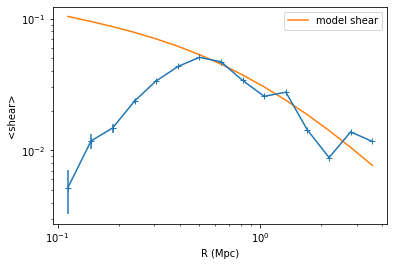

In [25]:
plt.errorbar(profile['radius'],profile['gt'],yerr=profile['gt_err'], marker='+')
plt.plot(profile['radius'],reduced_shear_model, label='model shear')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')